# A Machine Learning Pipeline to Predict Employee Attrition

When an employee leaves a company, their knowledge, skills and experience leave with them. It's difficult to replace each person who leaves, especially considering the high costs of sourcing, recruiting, and training employees. In addition to the costs, there is also lost productivity, which compounds the problem that employers face.

If HR departments and managers are able to predict who is a flight risk, and that individual would be a regrettable loss to the organization, they can take action before it is too late, and keep valuable employees with the company.

The goal of this project is to build a model to predict with a high degree of accuracy which employees are likely to leave the company, and highlight the most important factors in predicting attrition.

This is a binary classification problem, using supervised machine learning methods. 


In [1]:
import pandas as pd 
import numpy as np

import sklearn.model_selection 
import sklearn.preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection
The dataset can be found on Kaggle, in the following project:

https://www.kaggle.com/code/kerneler/starter-employee-turnover-prediction-d1fce5c5-2/data

`kaggle kernels output kerneler/starter-employee-turnover-prediction-d1fce5c5-2 -p /path/to/dest`

In [2]:
# importing and reviewing the data
df = pd.read_csv("../../datasets/employee_data.csv")

# apply lower case column names for usability
df.columns = df.columns.str.lower()

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# renaming columns to use more intuitive labels
df.columns = [
    "satisfaction",
    "evaluation",
    "projects",
    "hours_per_month",
    "tenure",
    "accident",
    "attrition",
    "promoted",
    "department",
    "salary",
]

# Data Exploration

The dataset contains the following features:

| Feature      | Description                                                   | Type       |
|--------------|---------------------------------------------------------------|------------|
| satisfaction | Employee's satisfaction level, as measured by internal survey | float
| evaluation | Employee's last performance evaluation | float
| projects | Number of projects that the employee works on | int
| hours_per_month | Average number of hours spent working each month | int 
| tenure | How long in years has the employee been with the company | int
| accident | Did the employee have a workplace accident (0 = no, 1 = yes) | int
| attrition | Did the employee stay (0) or leave (1) the company. **This is our target variable** | int
| promoted | Was the employee promoted during the past 5 years? (0 = no, 1 = yes) | int
| department | Company department where the employee works | object
| salary | Employee salary category (low, medium, high) | object

The pairplot below presents the distribution of features, with the target feature indicated by color. None of the features exhibits a normal distribution. The closest to a normal distribution may be last_evaluation (perhaps the company does performance ranking to curve). 

Several features are heavily imbalanced:
- 2.1% of employees were promoted in the past 5 years, so this feature is negatively skewed.
- 17% of employees had a workplace accident
- Tenure is negatively skewed, with a large number of employees at the company for a short time.

Visual inspection of the pairplot suggests a relationship between the target feature and some or all of the following features: satisfaction, evaluation, projects, and hours_per_month. This is quite intuitive - we can expect that a high number of hours per month and large number of projects, combined with low performance evaluation and low satisfaction could lead an employee to want to leave. In addition, it would be intuitive to expect that low salaries, risk of accident, and low opportunity for promotion could be predictors of attrition, although this is not evident in the pairplot.

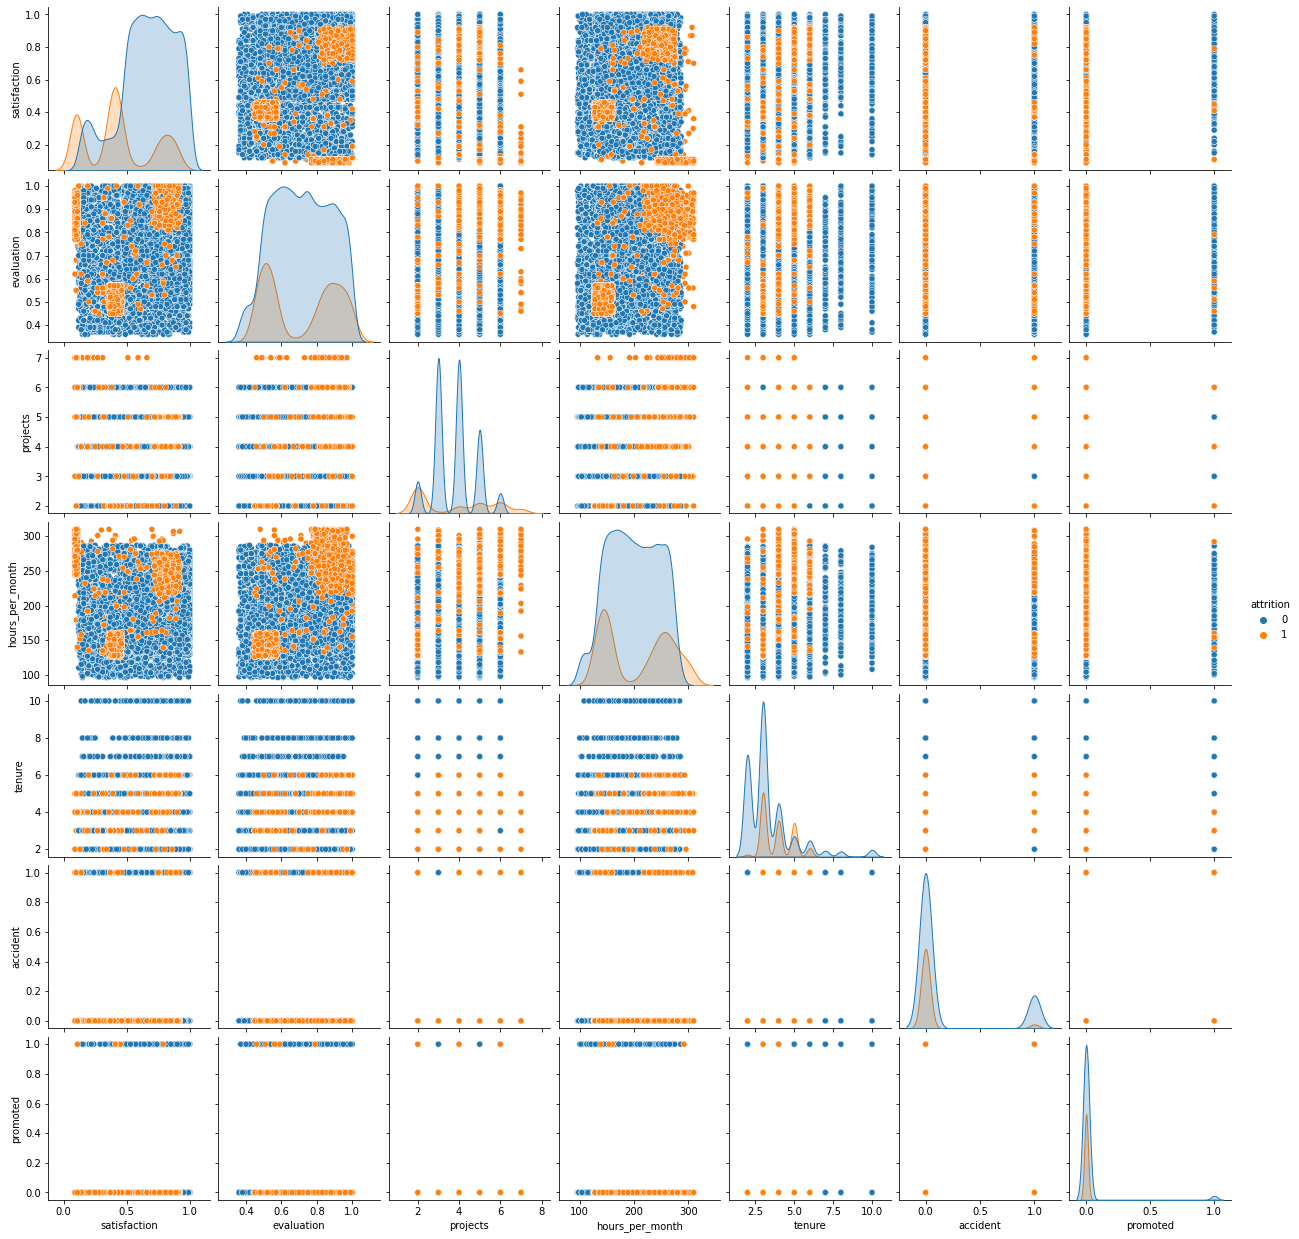

In [4]:
sns.pairplot(df, hue="attrition")

In [44]:
df.describe()

,satisfaction,evaluation,projects,hours_per_month,tenure,accident,attrition,promoted
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


This company's attrition rate is 24%.

Average satisfaction is at 61, and performance evaluations average at 71. Employees work on between 2 and 7 projects, with an average of 4.

As we do not know which industry this company is in, it is hard to judge whether this is high or low. Looking at the distribution of employees across department, shown below, we see that support, technical, IT, and RandD departments account for almost half of the employees. Therefore, it is very unlikely that this is a company in retail or hospitality - sectors that are known to have very high attrition rates. Most likely, this company is in a technical field with a lot of knowledge workers. If this comapany in the technology or manufacturing sectors, an attrition rate of 24% would be very high.

Average time spent at the company is short (~3.5 years), and half the workforce spends 200 or more hours at work per month. Considering that the IRS considers as a full-time employee anyone who works 130 hours per month or more, we can say that people at this company work long hours. In addition, promotion opportunities are rare - with only ~2% promoted in the past 5 years - which would appear to be well below industry norms  (for example, some IT firms aim to promote 10% of the workforce each year). 

Also, the fact that at this company, an employee is more likely to have a workplace accident (14%) than to get a promotion (2%) is remarkable.

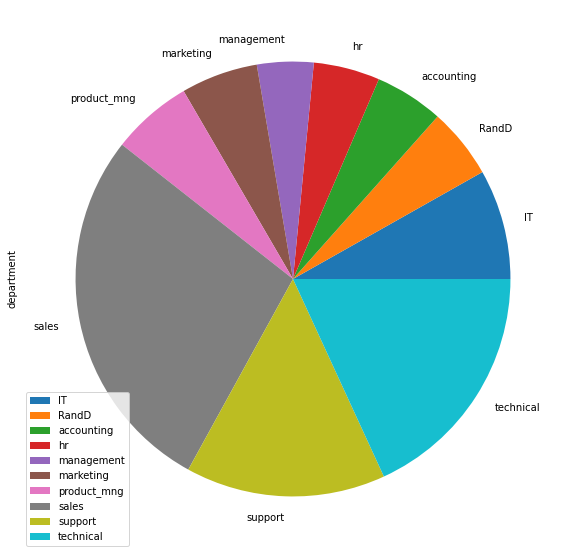

In [43]:
departments = df[['department']].groupby(df['department']).count()

plot = departments.plot.pie(y='department', figsize=(10, 10))
plt.legend(loc='lower left')


Of the 14,999 employees, 3,571 are recorded as having left the company (24%). 
Therefore, the dataset is imbalanced.

As this is a binary classification problem with imbalanced data, during model selection balanced accuracy will be used as the evaluation metric without resampling, and accuracy will be used with resampling. Precision, recall and F1 score will be used to assess the final model. 

# Data Preprocessing and Feature Engineering


### Encoding categorical features
Before we can prepare the dataset for learning, we must first encode categorical features so that they can be processed numerically. 

In [5]:
# Feature engineering: encode categorical features (department, salary) and concatenate with dataframe
enc = sklearn.preprocessing.OneHotEncoder()
df_object = df.select_dtypes('object')

enc.fit(df_object)

encoded = enc.transform(df_object).toarray()

feature_names = enc.get_feature_names(['dept', 'salary'])

df_enc = pd.concat([df.select_dtypes(exclude='object'),
               pd.DataFrame(encoded, columns=feature_names).astype(int)], axis=1)

### Review correlations
Any features that show perfect or near-perfect correlation with the target can influence the model in an undesirable way. It is important to review the correlation matrix, and consider dropping any features with very high correlation with the target variable.

The features with the strongest correlation with the target are satisfaction (-0.39), accident (-0.15), tenure (0.14), low salary (-0.13) and high salary (-0.12). None of these is particularly strong, so it is not necessary to drop any features.

attrition           1.000000
tenure              0.144822
salary_low          0.134722
hours_per_month     0.071287
dept_hr             0.028249
projects            0.023787
dept_technical      0.020076
dept_accounting     0.015201
dept_support        0.010700
dept_sales          0.009923
evaluation          0.006567
dept_marketing     -0.000859
dept_IT            -0.010925
dept_product_mng   -0.011029
dept_management    -0.046035
dept_RandD         -0.046596
promoted           -0.061788
salary_medium      -0.068833
salary_high        -0.120929
accident           -0.154622
satisfaction       -0.388375
Name: attrition, dtype: float64


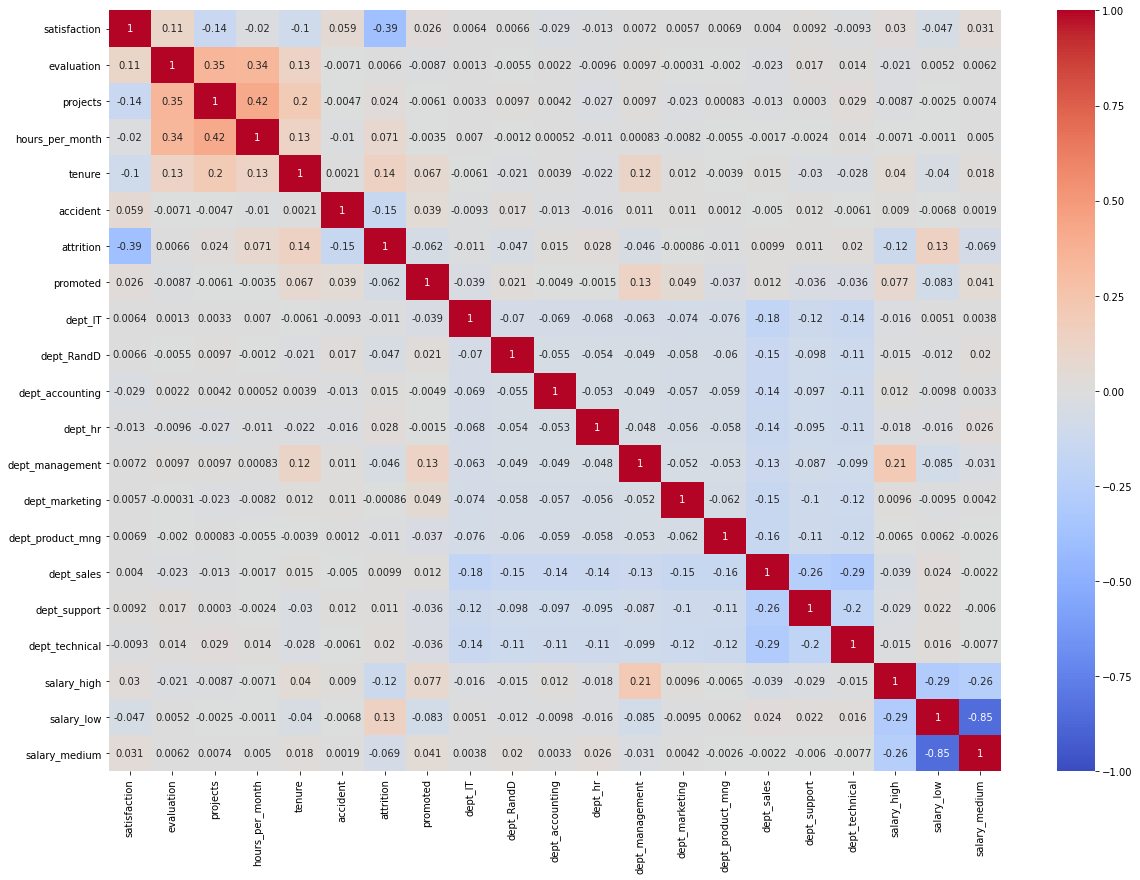

In [6]:
# visualizing correlations matrix
correlations = df_enc.corr()

fig, ax1 = plt.subplots(figsize=(20, 14))
sns.heatmap(correlations, cmap="coolwarm", vmin=-1, vmax=+1, annot=True, ax=ax1)

print(correlations['attrition'].sort_values(ascending=False))

### Split into Train and Test
Splitting the dataset into training and test (4:1 ratio, using the default settings).

In [7]:
# splitting the encoded dataframe into train and test; cut target feature out
X = df_enc.drop(["attrition"], axis=1)
y = df_enc["attrition"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

print("Encoded dataframe: ", df_enc.shape) 
print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape,)
print("y_train: ", y_train.shape) 
print("y_test: ", y_test.shape)

Encoded dataframe:  (14999, 21)
X_train:  (11249, 20)
X_test:  (3750, 20)
y_train:  (11249,)
y_test:  (3750,)


### Check for imbalanced data
In our target training data, we have a positive minority class because in 24% of cases the employee left the company. 

We have the following options to deal with this situation:
- ignore the imbalance in the data, and use balanced accuracy as the evaluation metric
- remove cases from the majority class until we have balanced data (undersampling)
- synthetically simulate new minority cases until we have balanced data (oversampling)

This analysis will try all three methods.

In [8]:
y_train.value_counts()

0    8534
1    2715
Name: attrition, dtype: int64

### Random Undersampling
This technique randomly removes data from the majority class until the data is balanced. The disadvantage of this method is that potentially valuable data can be lost from the dataset.

In [9]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

y_train_rus.value_counts()

0    2715
1    2715
Name: attrition, dtype: int64

### Synthetic Oversampling
This technique synthetically creates new data points and adds them to the minority class until the data is balanced. The disadvantage of this method is that it can generate a lot of duplicate values in the dataset.

In [10]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model Selection and Hyperparameter Tuning

As a binary classification problem, there are several machine learning algorithms that could be chosen. I will evaluate the following three.

## Binary Logistic Regression
This model uses a sigmoid function to determine the probability of a value belonging to one class or another. The dataset is a combination of continuous features (satisfaction, evaluation), and discrete features (salary, department, accident), which makes logistic regression a viable candidate.

In the model comparison scenario, the hyperparameters ```C``` and ```penalty``` will be used. It may also be necessary to set the ```max_iter``` parameter, depending on the size of the sample.

## K-Nearest Neighbor
This instance-based algorithm attempts to classify new datapoints based on previous instances. When training a model using this method, similar datapoints are grouped together, and the model returns the target label shared by those similar datapoints. This method can be time-consuming with large datasets. In this case, we are using a medium-sized dataset (14,999 * 20), and therefore this model is considered to be a viable candidate.

In the model comparison scenario, the hyperparameters ```k``` (number of neighbors), ```weights``` (weight function used in prediction), and ```metric``` (distance metric) will be used.


## Decision Tree Classifier
This non-parametric algorithm attempts to classify datapoints through a series of true/false decisions. This method is relatively easy to understand and to explain, which could be appreciated by our company's HR department. Decision trees are easy to visualize, and the hyperparameters are intuitive to use. One of the drawbacks of decision tree classifiers is that there is a risk of over-fitting.

In the model comparison scenario, the hyperparameters ```criterion``` (the function that measures the quality of a split),  ```max_depth``` (maximum depth of the tree), and ```min_samples_split``` (minimum number of samples needed to split a node) will be used.


## Cross Validation
As part of the model selection step, 5-fold cross validation is used. This means that over 5 trials, 20% of the data is used for validation, against 80% used for training, and the validation portion changes for each trial.

In [11]:
# initializing container variables

scenario = []
entries = []
best_params = []
score = []

### Model Selection Scenario #1: Without Sampling

In this scenario, no sampling is performed to address the data imbalance, and the selected evaluation metric is ```balanced_accuracy```. This metric is defined as the average of recall obtained on each class. This is a suitable model evaluation metric when working with imbalanced data. 

In [12]:
# model selection with imbalanced data and balanced accuracy score
models = [
    {
        "name": LogisticRegression(),
        "parameters_grid": {
            "C": [1, 10, 100, 1000],
            "penalty": ["l2"],
            "max_iter": [1000],
        },
    },
    {
        "name": KNeighborsClassifier(),
        "parameters_grid": {
            "n_neighbors": range(1, 20, 2),
            "weights": ["uniform", "distance"],
            "metric": ["minkowski", "euclidean", "manhattan"],
        },
    },
    {
        "name": DecisionTreeClassifier(),
        "parameters_grid": {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 20, 3),
            "min_samples_split": range(2, 20, 3),
        },
    },
]

for m in models:
    # write test case to containers
    entries.append(m["name"])
    scenario.append("Without Sampling")

    # generate the model, pass it to GridSearch with the parameters grid
    clf = m["name"]
    grid_search = sklearn.model_selection.GridSearchCV(
        estimator=clf,
        param_grid=m["parameters_grid"],
        scoring="balanced_accuracy",
        cv=5,
    )

    # fit the model and print the result
    grid_search.fit(X_train, y_train)
    
    # write results to containers
    best_params.append(grid_search.best_params_)
    score.append(grid_search.best_score_)

### Model Selection Scenario #2: Synthetic Oversampling

In this scenario, the random datapoints are synthetically generated and added to the minority class to address the data imbalance. The selected evaluation metric is ```accuracy_score```, which is defined as the percentage of correctly classified values. 

In [13]:
# model selection with simulated oversampling (SMOTE) and accuracy score

models = [
    {
        "name": LogisticRegression(),
        "parameters_grid": {
            "C": [1, 10, 100, 1000],
            "penalty": ["l2"],
            "max_iter": [5000],
        },
    },
    {
        "name": KNeighborsClassifier(),
        "parameters_grid": {
            "n_neighbors": range(1, 20, 2),
            "weights": ["uniform", "distance"],
            "metric": ["minkowski", "euclidean", "manhattan"],
        },
    },
    {
        "name": DecisionTreeClassifier(),
        "parameters_grid": {
            "criterion": ["gini", "entropy"],
            "max_depth": range(3, 20, 3),
            "min_samples_split": range(2, 20, 3),
        },
    },
]

for m in models:
    # write test case to containers
    entries.append(m["name"])
    scenario.append("Oversampling")

    # generate the model, pass it to GridSearch with the parameters grid
    clf = m["name"]
    grid_search = sklearn.model_selection.GridSearchCV(
        estimator=clf, param_grid=m["parameters_grid"], scoring="accuracy", cv=5
    )

    # fit the model and print the result
    grid_search.fit(X_train_smote, y_train_smote)
    
    # write results to containers
    best_params.append(grid_search.best_params_)
    score.append(grid_search.best_score_)

### Model Selection Scenario #3: Random Undersampling

In this scenario, the datapoints are randomly removed from the majority class until the data is balanced. The selected evaluation metric is ```accuracy_score```, as in scenario 2. 

In [14]:
# model selection with randmon undersampling and accuracy score

models = [
    { "name": LogisticRegression(),
      "parameters_grid": {
          'C': [1, 10, 100, 1000],
          "penalty":["l2"],
          'max_iter': [1000]

      }
     },
    { "name": KNeighborsClassifier(),
      "parameters_grid": {
          "n_neighbors": range(1, 20, 2),
          "weights": ['uniform','distance'],
          "metric": ["minkowski", "euclidean", "manhattan"]
        }
    },
    { "name": DecisionTreeClassifier(),
      "parameters_grid": {
          "criterion": ['gini','entropy'],
          "max_depth": range(1, 20, 3),
          "min_samples_split": range(2, 20, 3)
      }
    }
     ]

for m in models:
    # write test case to containers
    entries.append(m["name"])
    scenario.append("Undersampling")

    # generate the model, pass it to GridSearch with the parameters grid
    clf = m["name"]
    grid_search = sklearn.model_selection.GridSearchCV(
        estimator=clf, param_grid=m["parameters_grid"], scoring="accuracy", cv=5
    )

    # fit the model and print the result
    grid_search.fit(X_train_rus, y_train_rus)
    
    # write results to containers
    best_params.append(grid_search.best_params_)
    score.append(grid_search.best_score_)    

In [15]:
# assembling the evaluation dataframe

df_model_selection = pd.DataFrame(
    list(zip(scenario, entries, best_params, score)),
    columns=["scenario", "model", "best_params", "score"],
)
df_model_selection = df_model_selection.sort_values("score", ascending=False)
pd.set_option("display.max_colwidth", 1000)
df_model_selection


,scenario,model,best_params,score
2,Without Sampling,DecisionTreeClassifier(),"{'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2}",0.969849
5,Oversampling,DecisionTreeClassifier(),"{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2}",0.965491
8,Undersampling,DecisionTreeClassifier(),"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}",0.960958
4,Oversampling,KNeighborsClassifier(),"{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}",0.956586
1,Without Sampling,KNeighborsClassifier(),"{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}",0.954415
7,Undersampling,KNeighborsClassifier(),"{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}",0.924494
3,Oversampling,LogisticRegression(),"{'C': 1, 'max_iter': 5000, 'penalty': 'l2'}",0.805604
6,Undersampling,LogisticRegression(),"{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}",0.776059
0,Without Sampling,LogisticRegression(),"{'C': 1000, 'max_iter': 1000, 'penalty': 'l2'}",0.633087


## Model Selection - Evaluation

### Logistic Regression
The model with the lowest performance in all scenarios was Logistic Regression, and although it improved with oversampling, the final accuracy score of  was much lower than the other two models.

### K-NN
This model performed quite well with oversampling, and without sampling, with very similar scores of approximately 95%, and even a decent result without sampling, of 92%.

### Decision Tree Classifier
This model performed best in all scenarios, and it appears that both undersampling and undersampling had a slightly detrimental effect on the performance of the model. The best performance was found without resampling and using the balanced accuracy metric, of just below 97%.

The results are conclusive - the Decision Tree Classifier appears to be the most effective of the three models, in all scenarios. The fact that it performs best without sampling is also positive, as it means that we can move on to the next phase with the original data, and without using synthetic data, or losing data from our majority class.

# Hyperparameter Tuning with the Selected Model

To tune the model, first the parameters from best performing result in model selection are passed into the parameters grid. The remainder of the parameters grid passes in the following combinations of hyperparameters:

- splitter (best and random)
- max_leaf_nodes (ranging from 10 to 400, increasing in increments of 10)
- min_samples_leaf (ranging from 1 to 10, in increments of 2)

In [45]:
# hyperparameter tuning Decision Tree Classifier without sampling

parameters_grid = {
    "criterion": ["gini"],
    "max_depth": [16],
    "min_samples_split": [2],
    "splitter": ["best", "random"],
    "max_leaf_nodes": range(10, 300, 10),
    "min_samples_leaf": range(1, 10, 2),
}

clf_tun = sklearn.model_selection.GridSearchCV(
    sklearn.tree.DecisionTreeClassifier(),
    parameters_grid,
    scoring="balanced_accuracy",
    cv=5,
    n_jobs=-1,
)
clf_tun.fit(X_train, y_train)
print(clf_tun.best_params_, clf_tun.best_score_)

results_hyp_tuning = pd.concat(
    [
        pd.DataFrame(clf_tun.cv_results_["params"]),
        pd.DataFrame(clf_tun.cv_results_["mean_test_score"], columns=["balanced_accuracy"]),
    ],
    axis=1,
)
results_hyp_tuning = results_hyp_tuning.sort_values("balanced_accuracy", ascending=False)
results_hyp_tuning


{'criterion': 'gini', 'max_depth': 16, 'max_leaf_nodes': 220, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 0.9708866816497712


,criterion,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,splitter,balanced_accuracy
210,gini,16,220,1,2,best,0.970887
270,gini,16,280,1,2,best,0.970460
230,gini,16,240,1,2,best,0.970008
250,gini,16,260,1,2,best,0.969723
220,gini,16,230,1,2,best,0.969715
...,...,...,...,...,...,...,...
3,gini,16,10,3,2,random,0.861355
9,gini,16,10,9,2,random,0.859872
5,gini,16,10,5,2,random,0.854216
7,gini,16,10,7,2,random,0.849416


## Hyperparameter Tuning - Results
Hyperparameter tuning had a negligible impact on the model - improving the balanced accuracy by less than one percent. 

The resulting classification model is 16 layers deep, with a maximum number of leaf nodes of 220. This is, undoubtedly, a large tree, and it is too large to visualize. Also, there may be a risk that such a large tree has been overfit, and depending how well it generalizes to the test data, it may be necessary to do some pruning.

# Training the Model 
The best hyperparameters, as determined in the previous step, are now passed to the model and it is fit to the training data.

In [46]:
model = sklearn.tree.DecisionTreeClassifier(criterion='gini', 
                                            max_depth=16, 
                                            max_leaf_nodes=220, 
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            splitter='best').fit(X_train, y_train)

# Testing the Model
Now the model is used to predict the target values, and the target values are compared with the actual test values, in terms of accuracy score.

The tuned model performed slightly better on the test data than it did on the training data, returning a ```balanced_accuracy``` score of 97.56%.

In [47]:
y_predicted = model.predict(X_test)
balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_test, y_predicted)
balanced_accuracy

0.9756481343934276

# Model Assessment
Accuracy gives one simple indication to the model's effectiveness. To better assess the performance of the model, we need to also consider precision and recall.

- Precision is the number of true positives that the model predicts relative to the total positives values predicted by the model.
- Recall is the number of true positive that the model predicts relative to the total positive values in the sample.
- F1 is the harmonic mean of precision and recall.

In [48]:
precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y_test, y_predicted, average="binary"
)

print("Model precision: ", precision)
print("Model recall: ", recall)
print("Model F1: ", f1)


Model precision:  0.9693396226415094
Model recall:  0.9602803738317757
Model F1:  0.9647887323943661


The model achieved precision, recall and F1 values are presented above.

The confusion matrix below presents the True Positive, False Positive, True Negative, and False Negative results of the model.

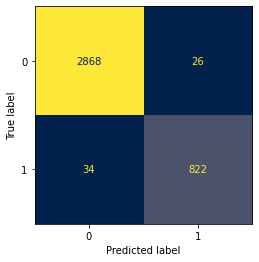

In [49]:
disp = sklearn.metrics.plot_confusion_matrix(model,  X_test, y_test, cmap = 'cividis', colorbar=False)

To visualize the performance of the model, we can plot the true positive rate (tpr) against the false positive rate (fpr), and get the area under the ROC curve (98%). A value of 50% indicates a useless model, and 100% indicates a perfect predictive model. Therefore, we can assess the current model as having high predictive power. 

In other words,  we can say that the model shows high sensitivity, that is a high percentage of the true positive cases were predicted. Also, the model shows high specificity, that is a high percentage of the true negative cases were predicted. 

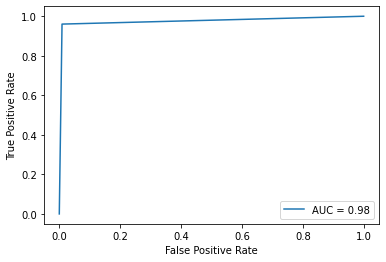

In [50]:
fpr, tpr, thresholds_dt = sklearn.metrics.roc_curve(y_test, y_predicted)
roc_auc = sklearn.metrics.auc(fpr, tpr)

display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

# Feature Importance

The table below presents the feature importances attribute of our trained model.

Satisfaction is highly important in predicting our target variable, attrition, with an importance level of over 50%. The next most important features are tenure, evaluation, projects, and hours per month. 

Perhaps surprisingly, low salary, work accidents, and promotions show very low scores in terms of feature importances.

In [51]:
df_features = pd.DataFrame(
    {"feature_names": X.columns, "importance": model.feature_importances_}
)
print(df_features.sort_values("importance", ascending=False))

total = sum(df_features["importance"])
print("Combined total of feature importances: ", total)


       feature_names  importance
0       satisfaction    0.506726
1         evaluation    0.148031
4             tenure    0.136744
2           projects    0.104236
3    hours_per_month    0.090811
18        salary_low    0.002132
16    dept_technical    0.002043
12    dept_marketing    0.001293
5           accident    0.001249
11   dept_management    0.001134
14        dept_sales    0.001061
9    dept_accounting    0.000976
8         dept_RandD    0.000814
19     salary_medium    0.000704
7            dept_IT    0.000562
15      dept_support    0.000544
17       salary_high    0.000431
10           dept_hr    0.000314
13  dept_product_mng    0.000196
6           promoted    0.000000
Combined total of feature importances:  0.9999999999999996


# Discussion and Conclusion

The goal of this analysis was to create a model that could accurately predict which employees were likely to leave the company. Several candidate models were tested, and a decision tree classifier proved to be the best. 

The resulting tree was large, but showed good performance on the test data. Also, the fact that precision and recall are within 1% of each other indicates that this model has found a good balance between sensitivity and specificity.

A surprising outcome is that lack of promotions and low salaries are not significant features in predicting attrition. Perhaps what are regarded as low salaries at the company are actually competitive in the market.

One important finding was the importance of satisfaction - it appears that this feature is the single strongest contributor to attrition, and is something that managers and HR professionals should take note of. The next most significant features are tenure, performance evaluation, number of projects and hours per month. My recommendation to this company would be to focus on satisfaction and ensuring employees have a challenging but sustainable workload. Address the attrition problem such that tenure no longer becomes an important feature. The longer an employee stays with an employer should not mean that they become more likely to leave. In fact, the opposite would be a sign of a good workplace. Number of projects, hours per month and evaluation are all pretty intuitive features that contribute to attrition, as when they are combined in a negative way, it is easy to imagine the toll they take on an employee. But, to reiterate, satisfaction stands out as the most influential factor, and this is something that managers should not ignore.

The recommended next steps would be to deploy this model into a production HR system, and test it with more real world data.
